# Windpower forecasting
Author: Karan Singh

In [498]:
import numpy as np
import pandas as pd

In [499]:
labels = pd.read_parquet('../case_power_forecasting/case_power_forecasting/data/labels.parquet', engine='pyarrow')
weather = pd.read_parquet('../case_power_forecasting/case_power_forecasting/data/weather_forecast.parquet', engine='pyarrow')

In [500]:
# Ensure that the labels are in 15 minute resolution
labels_index = pd.date_range(start=labels.index.min(), end=labels.index.max(), freq='15min')
labels.index = labels_index

In [501]:
# Add features -> part of day & Month
# Could temperature play a part? Is it cooler in the evenings/night?  
# Can the months represent seasons?    

conditions = [(0 <= labels.index.hour) & (labels.index.hour < 6), 
            (6 <= labels.index.hour) & (labels.index.hour < 12), 
            (12 <= labels.index.hour) & (labels.index.hour < 18), 
            (18 <= labels.index.hour) & (labels.index.hour < 24)]
choices = [0, 1, 2, 3]
labels['Day_part'] = np.select(condlist=conditions, choicelist=choices, default=np.nan)
labels['Month'] = labels.index.month
labels = labels[['Day_part', 'Month', 'power']]

In [502]:
labels.head()

,Day_part,Month,power
2019-01-01 00:00:00,0.0,1,48637.0
2019-01-01 00:15:00,0.0,1,52357.0
2019-01-01 00:30:00,0.0,1,54317.0
2019-01-01 00:45:00,0.0,1,54220.5
2019-01-01 01:00:00,0.0,1,51680.0


In [503]:
weather.head()

,Generation_Date,Forecast_Date,U,V,ws,Direction
1,2019-06-25,2019-06-25 01:00:00,1.861707,0.195582,1.871952,264.002783
2,2019-06-25,2019-06-25 02:00:00,1.257695,0.570511,1.381043,245.600179
3,2019-06-25,2019-06-25 03:00:00,1.883554,0.701067,2.009794,249.584514
4,2019-06-25,2019-06-25 04:00:00,2.664914,0.169917,2.670325,266.351713
5,2019-06-25,2019-06-25 05:00:00,2.855113,-0.255226,2.866498,275.108242


In [504]:
# Drop Generation_Date and make Forecast_Date the index 
weather = weather.drop('Generation_Date', axis=1).set_index('Forecast_Date')

In [505]:
weather.head()

,U,V,ws,Direction
Forecast_Date,,,,
2019-06-25 01:00:00,1.861707,0.195582,1.871952,264.002783
2019-06-25 02:00:00,1.257695,0.570511,1.381043,245.600179
2019-06-25 03:00:00,1.883554,0.701067,2.009794,249.584514
2019-06-25 04:00:00,2.664914,0.169917,2.670325,266.351713
2019-06-25 05:00:00,2.855113,-0.255226,2.866498,275.108242


In [506]:
# Merge the labels and weather data
data = pd.merge(left=labels, right=weather, left_index=True, right_index=True, how='left')

In [507]:
data.head()

,Day_part,Month,power,U,V,ws,Direction
2019-01-01 00:00:00,0.0,1,48637.0,NaN,NaN,NaN,NaN
2019-01-01 00:15:00,0.0,1,52357.0,NaN,NaN,NaN,NaN
2019-01-01 00:30:00,0.0,1,54317.0,NaN,NaN,NaN,NaN
2019-01-01 00:45:00,0.0,1,54220.5,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,0.0,1,51680.0,NaN,NaN,NaN,NaN


In [508]:
# Keep values from the start date of weather 
data = data[np.where(data.index == weather.index.min())[0][0]:]

In [509]:
data.head()

,Day_part,Month,power,U,V,ws,Direction
2019-06-25 01:00:00,0.0,6,4686.2,1.861707,0.195582,1.871952,264.002783
2019-06-25 01:15:00,0.0,6,4047.9,NaN,NaN,NaN,NaN
2019-06-25 01:30:00,0.0,6,3251.0,NaN,NaN,NaN,NaN
2019-06-25 01:45:00,0.0,6,2244.5,NaN,NaN,NaN,NaN
2019-06-25 02:00:00,0.0,6,2224.6,1.257695,0.570511,1.381043,245.600179


In [510]:
# Fill the hourly values forward to quarter hour 
data['U'] = data['U'].fillna(method='ffill')
data['V'] = data['V'].fillna(method='ffill')
data['ws'] = data['ws'].fillna(method='ffill')
data['Direction'] = data['Direction'].fillna(method='ffill')

In [511]:
# Rearrange so that power is the last column
data = data[['Day_part', 'Month', 'U', 'V', 'ws', 'Direction', 'power']]

In [512]:
data.head()

,Day_part,Month,U,V,ws,Direction,power
2019-06-25 01:00:00,0.0,6,1.861707,0.195582,1.871952,264.002783,4686.2
2019-06-25 01:15:00,0.0,6,1.861707,0.195582,1.871952,264.002783,4047.9
2019-06-25 01:30:00,0.0,6,1.861707,0.195582,1.871952,264.002783,3251.0
2019-06-25 01:45:00,0.0,6,1.861707,0.195582,1.871952,264.002783,2244.5
2019-06-25 02:00:00,0.0,6,1.257695,0.570511,1.381043,245.600179,2224.6


#### Use Random Forest Regression to impute missing power values

In [513]:
# Check for missing values
data.isna().sum()

Day_part       0
Month          0
U              0
V              0
ws             0
Direction      0
power        341
dtype: int64

In [514]:
rf_data = data[data['power'].notnull()] # Data with no missing values -> use this to train model
rf_data_inputs = rf_data.drop(['power'], axis=1)
rf_data_labels = rf_data['power']

In [515]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [516]:
X_train, X_test, y_train, y_test = train_test_split(rf_data_inputs, rf_data_labels, test_size=0.20)

In [517]:
rf_model = RandomForestRegressor(n_estimators=50)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.9682297631087473

In [518]:
# Get the values that are missing
pred_data = data[data['power'].isnull()].drop(['power'], axis=1)

In [519]:
predictions = rf_model.predict(pred_data)

In [520]:
# Replace the missing data with the predicted values
col = data.columns.get_loc('power')
for row, val in zip(np.where(data['power'].isnull())[0], predictions):
    data.iloc[row,col] = val

In [521]:
data.isnull().sum()

Day_part     0
Month        0
U            0
V            0
ws           0
Direction    0
power        0
dtype: int64

### Model building

In [522]:
np.set_printoptions(suppress=True)

In [523]:
# Date to split the training and testing
index_1Aug2020 = np.where(data.index == '2020-08-01 00:00:00')[0][0] 

training_data = data[:index_1Aug2020] 
testing_data = data[index_1Aug2020:]

In [524]:
# Ensure that training data starts at 00:15:00 and ends at 00:00:00
training_data = training_data.loc['2019-06-26 00:15:00':'2020-07-30 00:00:00'].values 

In [525]:
# Split the training data into chunks of 96
X = np.array(np.split(training_data, training_data.shape[0]//96))
X.shape

(400, 96, 7)

In [526]:
# Use the last column in the training data as the labels - except for the first instance
y = np.array([i[:,-1] for i in X[1:]])
y.shape

(399, 96)

In [527]:
# Delete the last X array -> make X & y the same size
X = X[:-1]
X.shape

(399, 96, 7)

In [528]:
# Flatten X
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
X.shape 

(399, 672)

In [529]:
# Set the output dimension
n_output = y.shape[1]

In [530]:
# Train test split approx 20%
X_train = X[:320]
X_test = X[320:]
y_train = y[:320]
y_test = y[320:]

In [531]:
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler(feature_range=(0, 1))
sc_Y = MinMaxScaler(feature_range=(0, 1))

In [532]:
# Normalize the data
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = sc_Y.fit_transform(y_train)
y_test = sc_Y.transform(y_test)

In [533]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [534]:
# Build a MLP 
# Use dropout layer to prevent over-fitting
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=n_input))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dense(n_output))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
320/320 [==============================] - 4s 6ms/step - loss: 0.0446
Epoch 2/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0319
Epoch 3/20
320/320 [==============================] - 2s 5ms/step - loss: 0.0286
Epoch 4/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0296
Epoch 5/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0285
Epoch 6/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0269
Epoch 7/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0262
Epoch 8/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0259
Epoch 9/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0280
Epoch 10/20
320/320 [==============================] - 2s 7ms/step - loss: 0.0245
Epoch 11/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0264
Epoch 12/20
320/320 [==============================] - 2s 6ms/step - loss: 0.0260
Epoch 13/20
320/320 [====

In [535]:
# Make predictions on X_test
testPredict = model.predict(X_test)

3/3 [==============================] - 0s 9ms/step


In [536]:
# Inverse the normalization
testPredict = sc_Y.inverse_transform(testPredict)
y_test = sc_Y.inverse_transform(y_test)

In [537]:
def norm_mean_abs_error(y_true, y_pred):
    ''' Custom loss function '''
    return 100*((np.sum(np.abs(y_true - y_pred))/y_true.size)/106400)

In [538]:
norm_mean_abs_error(y_test, testPredict)

9.86778227704991

## Make predictions on the testing data

In [539]:
# Drop the first instance and split the test data into chunks of 96
test_data = testing_data[1:].values
test_data_split = np.array(np.split(test_data , test_data.shape[0]//96))

In [540]:
test_data_split.shape

(91, 96, 7)

In [541]:
# Flatten test_data_split
n_input2 = test_data_split.shape[1] * test_data_split.shape[2]
test_data_flat = test_data_split.reshape((test_data_split.shape[0], n_input2))
test_data_flat.shape

(91, 672)

In [542]:
# Normalize the data
scaler_test = MinMaxScaler(feature_range=(0, 1))
test_data_scaled = sc_X.fit_transform(test_data_flat)

In [543]:
# Make predictions using the pre-trained model
yhat = model.predict(test_data_scaled)

3/3 [==============================] - 0s 9ms/step


In [544]:
# Inverse the normalization
yhat_invTrs = sc_Y.inverse_transform(yhat)
yhat_invTrs.shape

(91, 96)

In [545]:
# Flatten the data 
yhat_flat = yhat_invTrs.flatten()

In [546]:
# Create a dataframe
yhat_df = pd.DataFrame(yhat_flat,columns=['yhat'])
yhat_df.shape

(8736, 1)

In [547]:
# Create another dataframe with the power values and add the yhat predictions
y_yhat_df = pd.DataFrame(columns=['power'], index=testing_data.index)
y_yhat_df['power'] = testing_data['power'].values
y_yhat_df = y_yhat_df.iloc[1:]
y_yhat_df['yhat'] = yhat_df['yhat'].values

<AxesSubplot:title={'center':'Actual vs Predicted'}>

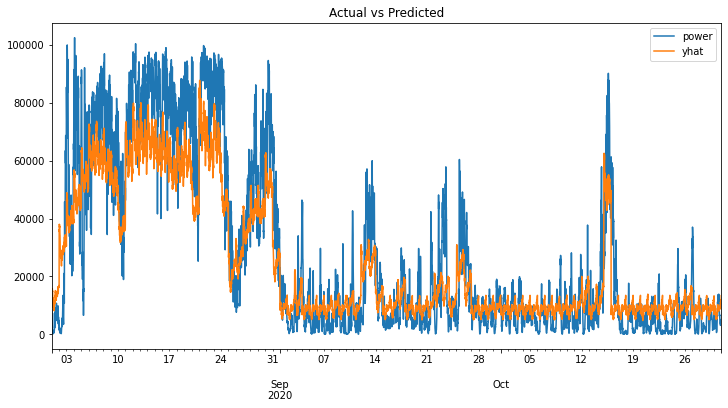

In [548]:
# Vizualise the actual vs predicted data
y_yhat_df.plot(figsize=(12,6), title='Actual vs Predicted')

In [549]:
# Calculate the NMAE% 
norm_mean_abs_error(y_true=y_yhat_df['power'].values, y_pred=y_yhat_df['yhat'].values)

9.583487680907908

## Next steps

* Are months and parts of the day ordinal or categorical data?<br>
    * Approach for cyclic ordinal data: __[cyclic_ordinal_link](https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes)__  
* Instead of MSE use the NMAE% loss metric as a custom loss function using Keras backend __[custom_loss_link]( https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras)__
* Hyper-parameter optimization: 
    * How to determine the number of layers, the neurons in the layers, drop-outs and activations. We can use a discrete optimization algorithm to try various combinations. The fitness function (accuracy, overfitting) will need to be defined and should be measurable. More thorough than Grid Search or Random search but can lead to complicated models.    
    * Optimize weights to reduce training time: Use this approach __[PSO_SGD_link](https://arxiv.org/pdf/2205.10456)__ : where SGD and PSO algorithm are used together to yield better values
* Generate more features: 
    * What is the “Precision Interval of Wind Power” __[PIWP_link](https://www.sciencedirect.com/science/article/pii/S1568494619303308)__?